## Transfer Learning Tuning_Hats:
  * model parameter and other information can be found below:
     * [source](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
     
  * base_model: use vgg16 and freeze at bottleneck layer (stop right before flatten layer) 
  * top_model: tune dense layers (parameters are inspired by source)
     * batch_size 16 seems to work best for small data set 
     
  * extra blog source for callbacks and saving models:
  
  [call_backs for best weights](https://machinelearningmastery.com/check-point-deep-learning-models-keras/)
  
  [saving models](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)
  

##### warnings: due to use binary setting in image generator, 0 means hat and 1 means no hat
  
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.
W0831 19:45:39.436929 140612679419712 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0831 19:45:39.437727 140612679419712 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



---
#### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint

---
#### Import train_df and test_df for hats

In [3]:
train_df = pd.read_pickle('../pickle_files/train_df_hat.pkl')
test_df = pd.read_pickle('../pickle_files/test_df_hat.pkl')

In [15]:
train_df.head(2)

,pic_id,hat
228,01047.jpg,hat
412,00331.jpg,not_hat


#### Get bottleneck features to tune top models

In [4]:
def save_bottleneck_features(train_df, test_df, label, batch_size):
    '''
    inputs:
    train_df, test_df: train and test dataframes saved in pickle_files folder
    label: a string, eyewear, hat, or beard
    batch_size: process images in batches
    outputs:
    saves bottleneck features inside folder tuning_data as npy file
    '''
    # intialize the vgg16 model 
    # make sure not to train the top layers 
    base_model = VGG16(weights = 'imagenet', include_top = False)
    # create train_generator and test_generator to get bottleneck inputs for train and test df 
    # remove zoom range for hats
    datagen = ImageDataGenerator(
       rescale=1./255,
        zoom_range= [0.8,1.7],
        shear_range=0.2,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)
    # make sure shuffle is False so we know the label follows the sequence of the dataframe 
    # so we can tune top_model 
    train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),
    class_mode = None)
    # get features saved as .npy in tunign_data folder 
    bottleneck_features_train = base_model.predict_generator(
        train_generator, train_df.shape[0]//batch_size)
    np.save(open('../tuning_data/bottleneck_features_train_hat_2.npy','wb'),
           bottleneck_features_train)
    
    test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),
    class_mode = None)
    bottleneck_features_test = base_model.predict_generator(
        test_generator, test_df.shape[0]//batch_size)
    np.save(open('../tuning_data/bottleneck_features_test_hat_2.npy','wb'),
           bottleneck_features_test)

#### Save bottleneck_features

In [5]:
save_bottleneck_features(train_df,test_df,'hat',16)

W0831 19:46:23.815192 140612679419712 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 19:46:23.816351 140612679419712 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 19:46:23.821155 140612679419712 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 19:46:23.842174 140612679419712 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Found 408 validated image filenames.
Found 102 validated image filenames.


### Quick tuning of top models 

In [7]:
def train_top_model(train_df, test_df, epoch, batch_size, label):
    '''
    inputs:
    train_df, test_df: dataframes saved in pickle_files to generate train and test labels 
    epoch: num of epochs in fit 
    batch_size: same as image generator batch size 
    label: a string, eyewear, hat, or beard
    output:
    saves model weights in a folder 
    '''
    train_data = np.load(open('../tuning_data/bottleneck_features_train_hat_2.npy','rb'))
    # make sure train_data and train_label have same num of samples
    train_label = np.array(train_df[label].map({'not_'+label:0, label:1}))[:-(train_df.shape[0]%batch_size)]
    
    test_data = np.load(open('../tuning_data/bottleneck_features_test_hat_2.npy','rb'))
    test_label = np.array(test_df[label].map({'not_'+label:0, label:1}))[:-(test_df.shape[0]%batch_size)]
    
    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    # checkpoint for best weights 
    filepath="../tuning_data/best_bottleneck_vgg_model_hat_2.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    model.fit(train_data, train_label,
             epochs=epoch,
             batch_size=batch_size,
             validation_data=(test_data,test_label),
             callbacks=callbacks_list)
    del model
    keras.backend.clear_session()

#### run train_top_model and save results in tuning_data

In [8]:
train_top_model(train_df, test_df, 50, 16, 'hat')

W0831 19:47:08.909641 140612679419712 deprecation.py:506] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0831 19:47:08.921878 140612679419712 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 19:47:08.931745 140612679419712 deprecation.py:323] From /home/mindy/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as n

Train on 400 samples, validate on 96 samples
Epoch 1/50
400/400 [==============================] - 1s 1ms/step - loss: 1.1851 - acc: 0.6425 - val_loss: 0.4833 - val_acc: 0.7500

Epoch 00001: val_acc improved from -inf to 0.75000, saving model to ../tuning_data/best_bottleneck_vgg_model_hat_2.h5
Epoch 2/50
400/400 [==============================] - 0s 182us/step - loss: 0.6246 - acc: 0.7250 - val_loss: 0.4907 - val_acc: 0.7188

Epoch 00002: val_acc did not improve from 0.75000
Epoch 3/50
400/400 [==============================] - 0s 197us/step - loss: 0.4751 - acc: 0.7800 - val_loss: 0.5121 - val_acc: 0.7500

Epoch 00003: val_acc did not improve from 0.75000
Epoch 4/50
400/400 [==============================] - 0s 187us/step - loss: 0.4093 - acc: 0.8175 - val_loss: 0.4525 - val_acc: 0.7604

Epoch 00004: val_acc improved from 0.75000 to 0.76042, saving model to ../tuning_data/best_bottleneck_vgg_model_hat_2.h5
Epoch 5/50
400/400 [==============================] - 0s 200us/step - loss: 0.

400/400 [==============================] - 0s 183us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 1.0865 - val_acc: 0.8125

Epoch 00043: val_acc did not improve from 0.84375
Epoch 44/50
400/400 [==============================] - 0s 187us/step - loss: 0.0036 - acc: 0.9975 - val_loss: 1.1693 - val_acc: 0.7917

Epoch 00044: val_acc did not improve from 0.84375
Epoch 45/50
400/400 [==============================] - 0s 187us/step - loss: 1.0917e-04 - acc: 1.0000 - val_loss: 1.1409 - val_acc: 0.8021

Epoch 00045: val_acc did not improve from 0.84375
Epoch 46/50
400/400 [==============================] - 0s 184us/step - loss: 1.2259e-04 - acc: 1.0000 - val_loss: 2.0975 - val_acc: 0.7292

Epoch 00046: val_acc did not improve from 0.84375
Epoch 47/50
400/400 [==============================] - 0s 193us/step - loss: 0.0074 - acc: 0.9975 - val_loss: 1.3135 - val_acc: 0.8229

Epoch 00047: val_acc did not improve from 0.84375
Epoch 48/50
400/400 [==============================] - 0s 182us/step - los

### Fine Tune Top Model to improve accuracy

In [20]:
def fine_tune_model(train_df, test_df,epoch, batch_size,label, print_model = True):
    # build VGG16 model and freeze top layers
    # input_shape: width, height, RGB (from image generator)
    model_vgg = VGG16(weights='imagenet',include_top=False, input_shape=(150,150,3))
    # build top model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
    top_model.add(Dense(256,activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    # load saved weights to fine tune parameters 
    top_model.load_weights('../tuning_data/best_bottleneck_vgg_model_hat_2.h5')
    # add top model to model
    model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))
    # we will tune last 5 layers of the model: block5 and fully connected layer 
    for layer in model.layers[:15]:
        layer.trainable = False
    # we can tune the parameters for lr and momentum later to get better results
    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
             metrics=['accuracy'])
    # prepare train generator using data augmentation to battle small sample size 
    train_gen = ImageDataGenerator(
       rescale=1./255,
        zoom_range= [0.8,1.7],
        shear_range=0.2,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)
    # not want to augment the test 
    test_gen = ImageDataGenerator(rescale=1./255)
    
    train_generator =  train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(150,150),
    class_mode = 'binary')
    
    test_generator =  test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(150,150),
    class_mode = 'binary')
    
    # checkpoint for best weights 
    filepath="../tuning_data/best_vgg_model_hat_2.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # run and fit model 
    result = model.fit_generator(
    train_generator,
    steps_per_epoch=train_df.shape[0]//batch_size,
    epochs=epoch,
    validation_data=test_generator,
    validation_steps=test_df.shape[0]//batch_size,
    verbose=1, callbacks=callbacks_list)
    
    # model.save_weights('../tuning_data/vgg16_model_hat.h5')
    
    if print_model:
        model.summary()
    del model
    keras.backend.clear_session()    
    return result

### save model history 

In [21]:
model_history = fine_tune_model(train_df, test_df,100,16,'hat')

Found 408 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.
Epoch 1/100
25/25 [==============================] - 3s 130ms/step - loss: 2.4576 - acc: 0.3150 - val_loss: 0.7858 - val_acc: 0.5104

Epoch 00001: val_acc improved from -inf to 0.51042, saving model to ../tuning_data/best_vgg_model_hat_2.h5
Epoch 2/100
25/25 [==============================] - 3s 139ms/step - loss: 0.7709 - acc: 0.4500 - val_loss: 0.7099 - val_acc: 0.4884

Epoch 00002: val_acc did not improve from 0.51042
Epoch 3/100
25/25 [==============================] - 3s 135ms/step - loss: 0.7235 - acc: 0.5126 - val_loss: 0.7458 - val_acc: 0.4535

Epoch 00003: val_acc did not improve from 0.51042
Epoch 4/100
25/25 [==============================] - 3s 135ms/step - loss: 0.7120 - acc: 0.5024 - val_loss: 0.6984 - val_acc: 0.5814

Epoch 00004: val_acc improved from 0.51042 to 0.58140, saving model to ../tuning_data/best_vgg_model_hat_2.h5
Epoch 5/100
25/25 [========

25/25 [==============================] - 3s 132ms/step - loss: 0.2469 - acc: 0.9024 - val_loss: 0.3532 - val_acc: 0.8488

Epoch 00040: val_acc did not improve from 0.91860
Epoch 41/100
25/25 [==============================] - 3s 118ms/step - loss: 0.2820 - acc: 0.8850 - val_loss: 0.2277 - val_acc: 0.9186

Epoch 00041: val_acc improved from 0.91860 to 0.91860, saving model to ../tuning_data/best_vgg_model_hat_2.h5
Epoch 42/100
25/25 [==============================] - 3s 116ms/step - loss: 0.2216 - acc: 0.9176 - val_loss: 0.3009 - val_acc: 0.8488

Epoch 00042: val_acc did not improve from 0.91860
Epoch 43/100
25/25 [==============================] - 3s 135ms/step - loss: 0.2398 - acc: 0.9074 - val_loss: 0.2726 - val_acc: 0.8750

Epoch 00043: val_acc did not improve from 0.91860
Epoch 44/100
25/25 [==============================] - 4s 143ms/step - loss: 0.2462 - acc: 0.9175 - val_loss: 0.2688 - val_acc: 0.8721

Epoch 00044: val_acc did not improve from 0.91860
Epoch 45/100
25/25 [========

25/25 [==============================] - 3s 129ms/step - loss: 0.1590 - acc: 0.9501 - val_loss: 0.2523 - val_acc: 0.8953

Epoch 00083: val_acc did not improve from 0.94186
Epoch 84/100
25/25 [==============================] - 3s 118ms/step - loss: 0.1574 - acc: 0.9425 - val_loss: 0.2059 - val_acc: 0.9186

Epoch 00084: val_acc did not improve from 0.94186
Epoch 85/100
25/25 [==============================] - 3s 124ms/step - loss: 0.1145 - acc: 0.9599 - val_loss: 0.2707 - val_acc: 0.8958

Epoch 00085: val_acc did not improve from 0.94186
Epoch 86/100
25/25 [==============================] - 3s 139ms/step - loss: 0.1398 - acc: 0.9500 - val_loss: 0.2055 - val_acc: 0.9070

Epoch 00086: val_acc did not improve from 0.94186
Epoch 87/100
25/25 [==============================] - 3s 127ms/step - loss: 0.0892 - acc: 0.9750 - val_loss: 0.2700 - val_acc: 0.8721

Epoch 00087: val_acc did not improve from 0.94186
Epoch 88/100
25/25 [==============================] - 3s 111ms/step - loss: 0.1218 - acc

In [22]:
highest_val_acc, highest_train_acc = max(model_history.history['val_acc']), max(model_history.history['acc'])
print(f'highest test accuracy: {highest_val_acc}')
print('------------------')
print(f'highest train accuracy: {highest_train_acc}')

highest test accuracy: 0.9767441860465116
------------------
highest train accuracy: 0.9739583333333334


In [23]:
lowest_val_loss, lowest_train_loss = min(model_history.history['val_loss']), min(model_history.history['loss'])
print(f'lowest test loss: {lowest_val_loss}')
print('------------------')
print(f'lowest train loss: {lowest_train_loss}')

lowest test loss: 0.10918430594164272
------------------
lowest train loss: 0.08549906374240408


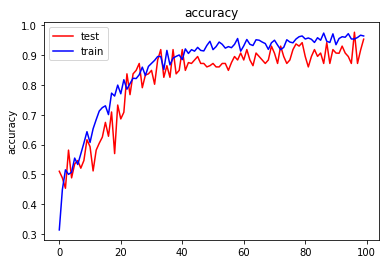

In [24]:
plt.plot(model_history.history['val_acc'], color = 'red', label = 'test')
plt.plot(model_history.history['acc'], color = 'blue', label = 'train')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.show()

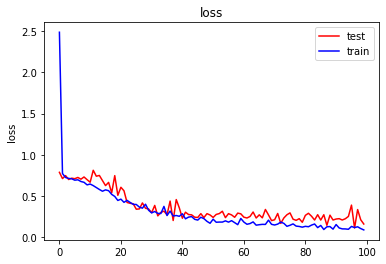

In [25]:
plt.plot(model_history.history['val_loss'], color = 'red', label = 'test')
plt.plot(model_history.history['loss'], color = 'blue', label = 'train')
plt.title('loss')
plt.ylabel('loss')
plt.legend()
plt.show()

### Save model 

In [16]:
# save model artchitecture 
hat_model = model_history.model
hat_model_json = hat_model.to_json()

In [17]:
# serialize model to JSON
with open("hat_model.json", "w") as json_file:
    json_file.write(hat_model_json)

In [4]:
# load json and create model
json_file = open('../tuning_data/eyewear_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_hat = model_from_json(loaded_model_json)

W0829 20:56:06.615755 140252431918912 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 20:56:06.626470 140252431918912 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 20:56:06.633198 140252431918912 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 20:56:06.636849 140252431918912 deprecation.py:506] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be rem

In [5]:
# load model weight 
loaded_model_hat.load_weights('../tuning_data/best_vgg_model_hat.h5')

In [6]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator =  test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col='hat',
    batch_size=16,
    target_size=(150,150),
    class_mode = 'binary')

Found 102 validated image filenames belonging to 2 classes.


In [7]:
loaded_model_hat.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
             metrics=['accuracy'])

W0829 20:56:17.106271 140252431918912 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 20:56:17.110955 140252431918912 deprecation.py:323] From /home/mindy/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
loaded_model_hat.evaluate_generator(test_generator)

[0.24847973094267004, 0.9215686286196989]

In [9]:
feature, label = next(test_generator)

In [19]:
label[0]

0.0

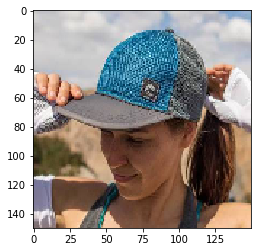

In [20]:
plt.imshow(feature[0])
plt.show()

In [18]:
# save the model
np.around(loaded_model_hat.predict_generator(test_generator))

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],